# ResNet Model Training

This notebook contains model training process for ResNet model on three different deepfake detection datasets. The model training splitted into two parts, which are baseline model (base model without dropout) and the dropout model itself.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152, resnet
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import pickle
import os

## Define Dataset Directory

In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC"

In [3]:
cdf_train_dir = os.path.join(CDF_DATASET_DIR, "Train")
cdf_val_dir = os.path.join(CDF_DATASET_DIR, "Val")

df_train_dir = os.path.join(DF_DATASET_DIR, "Train")
df_val_dir = os.path.join(DF_DATASET_DIR, "Val")

dfdc_train_dir = os.path.join(DFDC_DATASET_DIR, "Train")
dfdc_val_dir = os.path.join(DFDC_DATASET_DIR, "Val")

## Image Data Generator for Each Dataset

In [4]:
def create_image_generator(dataset_dir):
    datagen = ImageDataGenerator(preprocessing_function=resnet.preprocess_input)
    image_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(128, 128),
        batch_size=32,
        color_mode="rgb",
        class_mode="binary",
        shuffle=True,
        seed=42
    )

    return image_generator

In [5]:
print("Celeb-DF-v2 Dataset")
cdf_train_generator = create_image_generator(cdf_train_dir)
cdf_val_generator = create_image_generator(cdf_val_dir)

print("\nDeeperForensics-1.0 Dataset")
df_train_generator = create_image_generator(df_train_dir)
df_val_generator = create_image_generator(df_val_dir)

print("\nDeepfake Detection Challenge Dataset")
dfdc_train_generator = create_image_generator(dfdc_train_dir)
dfdc_val_generator = create_image_generator(dfdc_val_dir)

Celeb-DF-v2 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

DeeperForensics-1.0 Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.

Deepfake Detection Challenge Dataset
Found 14000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Get the Best Hyperparameters from Tuner

In [6]:
TUNER_RESULT_DIR = "/kaggle/input/hp-tuning/tuner-result"
TUNER_PROJECT_NAME = "cnn-best-hp"

In [7]:
tuner = kt.Hyperband(directory=TUNER_RESULT_DIR,
                     project_name=TUNER_PROJECT_NAME,
                     objective="val_accuracy",
                     overwrite=False)

Reloading Tuner from /kaggle/input/hp-tuning/tuner-result/cnn-best-hp/tuner0.json


In [8]:
best_hp = tuner.get_best_hyperparameters()[0].values
best_hp

{'conv_layers': 6,
 'conv_1_filters': 256,
 'conv_2_filters': 32,
 'conv_3_filters': 160,
 'conv_1_kernel_size': 3,
 'conv_2_kernel_size': 5,
 'conv_3_kernel_size': 5,
 'dense_layers': 6,
 'dense_1_layer_units': 128,
 'dense_2_layer_units': 96,
 'dropout_rate': 0.6000000000000001,
 'learning_rate': 1e-05,
 'dense_3_layer_units': 96,
 'dense_4_layer_units': 96,
 'dense_5_layer_units': 64,
 'conv_4_filters': 128,
 'conv_4_kernel_size': 5,
 'conv_5_filters': 192,
 'conv_6_filters': 128,
 'conv_7_filters': 224,
 'conv_5_kernel_size': 5,
 'conv_6_kernel_size': 5,
 'conv_7_kernel_size': 3,
 'dense_6_layer_units': 128,
 'dense_7_layer_units': 32,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0023'}

## Function to Create a ResNet Model

In [9]:
def create_resnet_model(hp, dropout=False, name="resnet_model"):
    base_model = ResNet152(include_top=False, weights="imagenet", input_shape=(128, 128, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = tf.keras.Sequential(name=name)
    model.add(tf.keras.layers.Input(shape=(128, 128, 3)))
    model.add(base_model)
    model.add(tf.keras.layers.Flatten(name="flatten"))

    for i in range(hp.get("dense_layers")):
        dense_units = hp.get(f"dense_{i+1}_layer_units")
        model.add(
            tf.keras.layers.Dense(dense_units, activation="relu", name=f"dense_{i+1}")
        )

    if dropout:
        model.add(tf.keras.layers.Dropout(hp.get("dropout_rate"), name="dropout"))

    model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get("learning_rate")),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )

    return model

## Function to Plot Train Results

In [10]:
def plot_train_result(history, title="Training Result"):
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Val")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## Function to Save Model Training History

In [11]:
def save_model_and_history(model, history, model_name):
    model_filename = f"{model_name}_model.keras"
    history_filename = f"{model_name}_history.pkl"

    model.save(model_filename)
    print(f"Model saved at {model_filename}")    

    with open(history_filename, "wb") as f:
        pickle.dump(history.history, f)
        print(f"Training history saved at {history_filename}")

## Model Training

In [12]:
NUM_EPOCHS = 10

### Baseline ResNet

#### Celeb-DF-v2 Dataset

In [13]:
baseline_resnet_cdf_model = create_resnet_model(best_hp, name="baseline_resnet_cdf_model")
baseline_resnet_cdf_model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "baseline_resnet_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [14]:
baseline_resnet_cdf_history = baseline_resnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731544383.068820     108 service.cc:145] XLA service 0x7f3a98005050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731544383.068896     108 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/438 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.4375 - loss: 0.8567   

I0000 00:00:1731544391.478200     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 218ms/step - accuracy: 0.5637 - loss: 0.6708 - val_accuracy: 0.6660 - val_loss: 0.6301
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9104 - loss: 0.2833 - val_accuracy: 0.7050 - val_loss: 0.6616
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9775 - loss: 0.0964 - val_accuracy: 0.6930 - val_loss: 0.8280
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9911 - loss: 0.0461 - val_accuracy: 0.7070 - val_loss: 0.8805
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9963 - loss: 0.0223 - val_accuracy: 0.7165 - val_loss: 0.9937
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9989 - loss: 0.0126 - val_accuracy: 0.7045 - val_loss: 1.0865
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9983 - loss: 0.0076 - val_accuracy: 0.7070 - val_loss: 1.1942
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accur

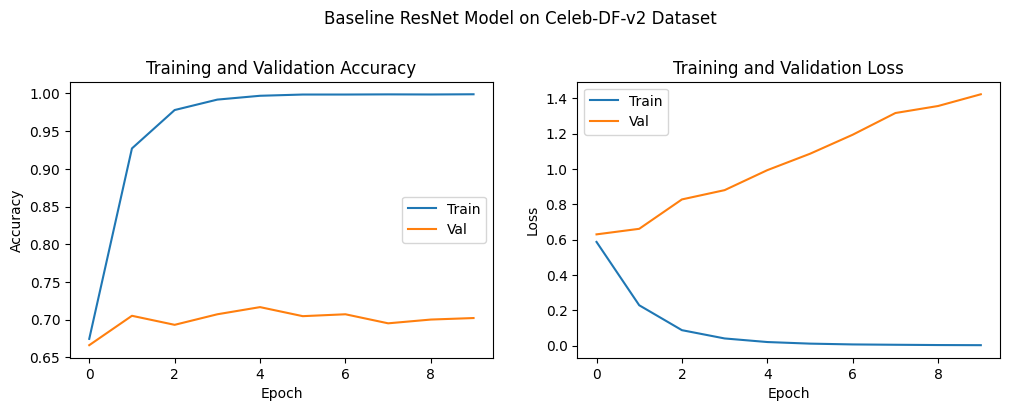

In [15]:
plot_train_result(
    baseline_resnet_cdf_history.history,
    title="Baseline ResNet Model on Celeb-DF-v2 Dataset"
)

In [16]:
save_model_and_history(
    baseline_resnet_cdf_model, baseline_resnet_cdf_history, "baseline_resnet_cdf"
)

Model saved at baseline_resnet_cdf_model.keras
Training history saved at baseline_resnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [17]:
baseline_resnet_df_model = create_resnet_model(best_hp, name="baseline_resnet_df_model")
baseline_resnet_df_model.summary()

Model: "baseline_resnet_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [18]:
baseline_resnet_df_history = baseline_resnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 130s 235ms/step - accuracy: 0.7819 - loss: 0.4436 - val_accuracy: 0.8370 - val_loss: 0.3517
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.9943 - loss: 0.0316 - val_accuracy: 0.8740 - val_loss: 0.2848
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.8775 - val_loss: 0.2771
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.9996 - loss: 0.0042 - val_accuracy: 0.8775 - val_loss: 0.2963
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.8660 - val_loss: 0.3362
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.8540 - val_loss: 0.3851
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9999 - loss: 8.6950e-04 - val_accuracy: 0.9025 - val_loss: 0.2518
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 1.0000 - loss: 8.0

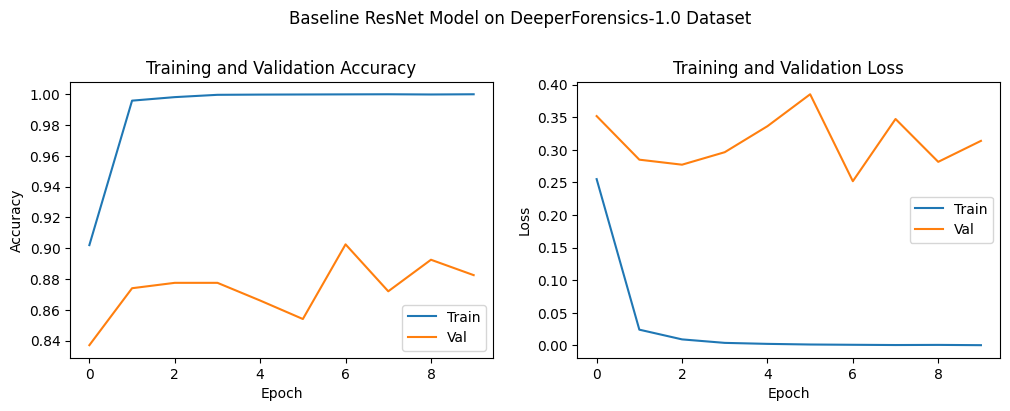

In [19]:
plot_train_result(
    baseline_resnet_df_history.history,
    title="Baseline ResNet Model on DeeperForensics-1.0 Dataset"
)

In [20]:
save_model_and_history(
    baseline_resnet_df_model, baseline_resnet_df_history, "baseline_resnet_df"
)

Model saved at baseline_resnet_df_model.keras
Training history saved at baseline_resnet_df_history.pkl


#### DFDC Dataset

In [21]:
baseline_resnet_dfdc_model = create_resnet_model(best_hp, name="baseline_resnet_dfdc_model")
baseline_resnet_dfdc_model.summary()

Model: "baseline_resnet_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [22]:
baseline_resnet_dfdc_history = baseline_resnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 122s 219ms/step - accuracy: 0.7053 - loss: 0.5834 - val_accuracy: 0.5985 - val_loss: 0.7537
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - accuracy: 0.9567 - loss: 0.1722 - val_accuracy: 0.6455 - val_loss: 0.8109
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9879 - loss: 0.0604 - val_accuracy: 0.6120 - val_loss: 0.9779
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.9954 - loss: 0.0281 - val_accuracy: 0.6360 - val_loss: 1.0195
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9977 - loss: 0.0151 - val_accuracy: 0.5970 - val_loss: 1.3947
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9994 - loss: 0.0093 - val_accuracy: 0.6540 - val_loss: 1.1450
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.9994 - loss: 0.0055 - val_accuracy: 0.6215 - val_loss: 1.3930
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 1.0000 - loss: 0.0028 

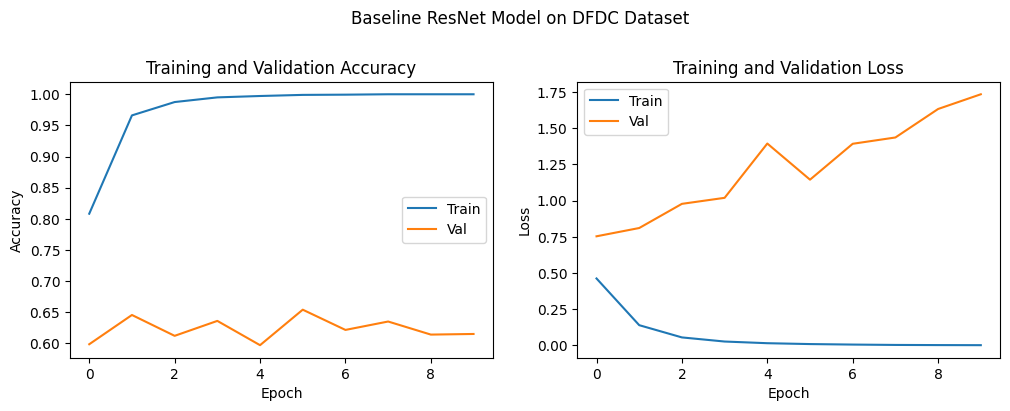

In [23]:
plot_train_result(
    baseline_resnet_dfdc_history.history,
    title="Baseline ResNet Model on DFDC Dataset"
)

In [24]:
save_model_and_history(
    baseline_resnet_dfdc_model, baseline_resnet_dfdc_history, "baseline_resnet_dfdc"
)

Model saved at baseline_resnet_dfdc_model.keras
Training history saved at baseline_resnet_dfdc_history.pkl


### Dropout ResNet Model Training

#### Celeb-DF-v2 Dataset

In [25]:
dropout_resnet_cdf_model = create_resnet_model(best_hp, dropout=True, name="dropout_resnet_cdf_model")
dropout_resnet_cdf_model.summary()

Model: "dropout_resnet_cdf_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [26]:
dropout_resnet_cdf_history = dropout_resnet_cdf_model.fit(
    cdf_train_generator, validation_data=cdf_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - accuracy: 0.5724 - loss: 0.6753 - val_accuracy: 0.6835 - val_loss: 0.5879
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.8324 - loss: 0.4128 - val_accuracy: 0.7490 - val_loss: 0.5567
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.9382 - loss: 0.1932 - val_accuracy: 0.7295 - val_loss: 0.6412
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9738 - loss: 0.0996 - val_accuracy: 0.7405 - val_loss: 0.7145
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9859 - loss: 0.0587 - val_accuracy: 0.7485 - val_loss: 0.7744
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9944 - loss: 0.0319 - val_accuracy: 0.7650 - val_loss: 0.8684
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9957 - loss: 0.0215 - val_accuracy: 0.7530 - val_loss: 1.0774
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9965 - loss: 0.0169 -

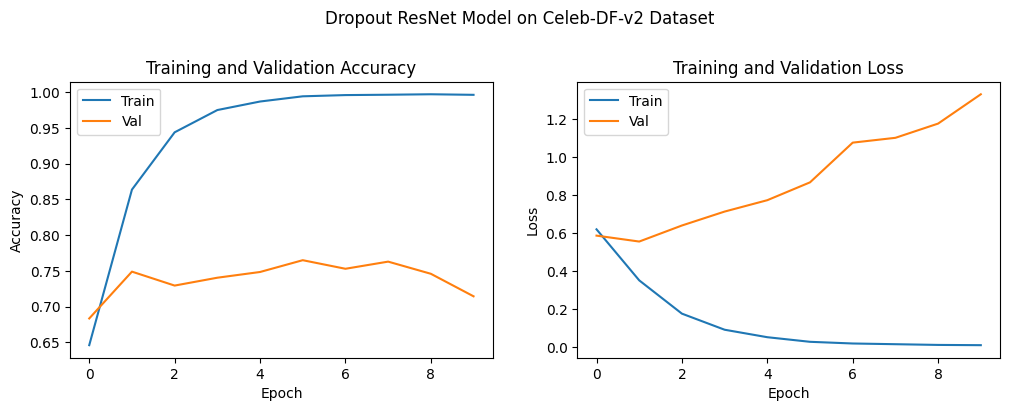

In [27]:
plot_train_result(
    dropout_resnet_cdf_history.history,
    title="Dropout ResNet Model on Celeb-DF-v2 Dataset"
)

In [28]:
save_model_and_history(
    dropout_resnet_cdf_model, dropout_resnet_cdf_history, "dropout_resnet_cdf"
)

Model saved at dropout_resnet_cdf_model.keras
Training history saved at dropout_resnet_cdf_history.pkl


#### DeeperForensics-1.0 Dataset

In [29]:
dropout_resnet_df_model = create_resnet_model(best_hp, dropout=True, name="dropout_resnet_df_model")
dropout_resnet_df_model.summary()

Model: "dropout_resnet_df_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [30]:
dropout_resnet_df_history = dropout_resnet_df_model.fit(
    df_train_generator, validation_data=df_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 75s 109ms/step - accuracy: 0.7059 - loss: 0.5384 - val_accuracy: 0.8885 - val_loss: 0.2654
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9774 - loss: 0.0948 - val_accuracy: 0.9110 - val_loss: 0.2061
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9922 - loss: 0.0338 - val_accuracy: 0.9100 - val_loss: 0.2197
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9967 - loss: 0.0160 - val_accuracy: 0.9285 - val_loss: 0.1714
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9985 - loss: 0.0092 - val_accuracy: 0.9350 - val_loss: 0.1612
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.9990 - loss: 0.0073 - val_accuracy: 0.9325 - val_loss: 0.1640
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9245 - val_loss: 0.1934
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.9993 - loss: 0.0032 -

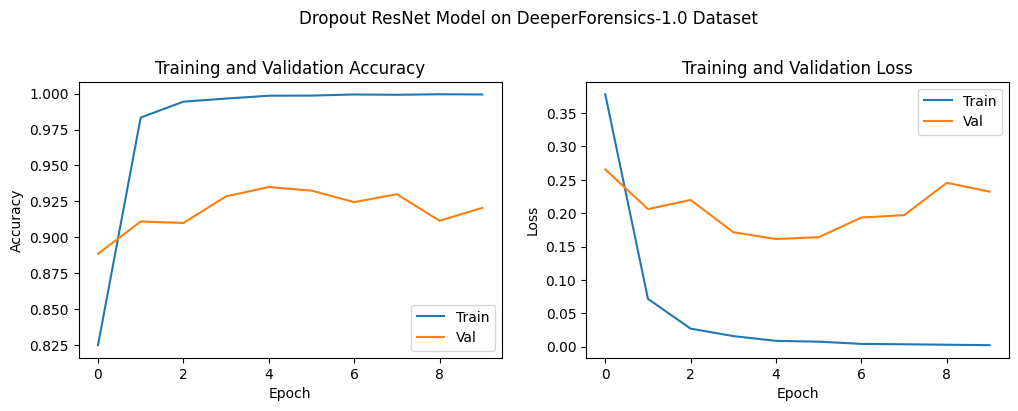

In [31]:
plot_train_result(
    dropout_resnet_df_history.history,
    title="Dropout ResNet Model on DeeperForensics-1.0 Dataset"
)

In [32]:
save_model_and_history(
    dropout_resnet_df_model, dropout_resnet_df_history, "dropout_resnet_df"
)

Model saved at dropout_resnet_df_model.keras
Training history saved at dropout_resnet_df_history.pkl


#### DFDC Dataset

In [33]:
dropout_resnet_dfdc_model = create_resnet_model(best_hp, dropout=True, name="dropout_resnet_dfdc_model")
dropout_resnet_dfdc_model.summary()

Model: "dropout_resnet_dfdc_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 4, 4, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,611,041 (238.84 MB)

 Trainable params: 4,240,097 (16.17 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [34]:
dropout_resnet_dfdc_history = dropout_resnet_dfdc_model.fit(
    dfdc_train_generator, validation_data=dfdc_val_generator, epochs=NUM_EPOCHS
)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 73s 104ms/step - accuracy: 0.5650 - loss: 0.6789 - val_accuracy: 0.5580 - val_loss: 0.6838
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.8312 - loss: 0.4062 - val_accuracy: 0.5805 - val_loss: 0.8754
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9509 - loss: 0.1573 - val_accuracy: 0.5805 - val_loss: 1.0621
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9827 - loss: 0.0740 - val_accuracy: 0.6105 - val_loss: 1.1562
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9901 - loss: 0.0390 - val_accuracy: 0.6030 - val_loss: 1.4098
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9931 - loss: 0.0279 - val_accuracy: 0.5920 - val_loss: 1.6732
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step - accuracy: 0.9965 - loss: 0.0183 - val_accuracy: 0.6145 - val_loss: 1.4610
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.9974 - loss: 0.0138 -

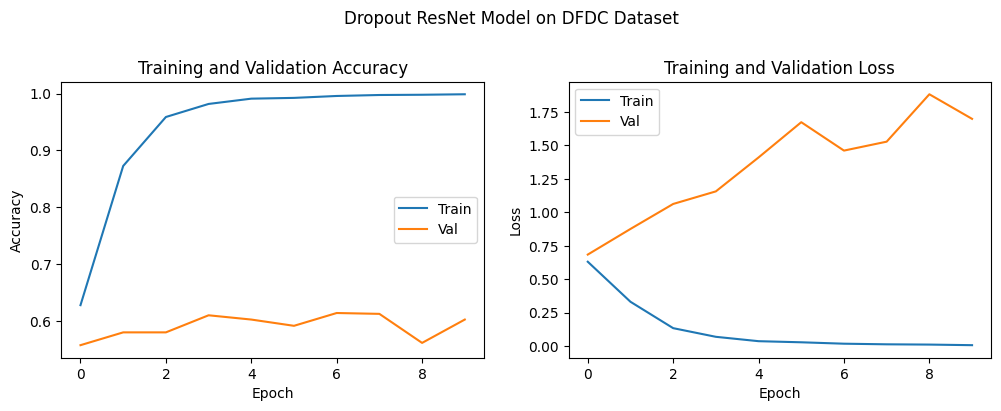

In [35]:
plot_train_result(
    dropout_resnet_dfdc_history.history,
    title="Dropout ResNet Model on DFDC Dataset"
)

In [36]:
save_model_and_history(
    dropout_resnet_dfdc_model, dropout_resnet_dfdc_history, "dropout_resnet_dfdc"
)

Model saved at dropout_resnet_dfdc_model.keras
Training history saved at dropout_resnet_dfdc_history.pkl
